In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision # Import torchvision
from torchvision.models import vit_b_16, ViT_B_16_Weights # Import ViT model and weights
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold  # Import for StratifiedKFold

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


In [3]:
#資料集路徑
# dataset_folder = '/kaggle/input/bsc5-spectrogramsamplitude/BSC5_Spectrograms(Amplitude)'
# dataset_folder = '/kaggle/input/bsc5-spectrogramspower/BSC5_Spectrograms(Power)'
dataset_folder = '/kaggle/input/bsc5-spectrogramsdb/BSC5_Spectrograms(DB)'
#--------------------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/bsc5-adaf-spectrograms-128amplitude/BSC5_Adaf_Spectrograms_128(Amplitude)'
# dataset_folder = '/kaggle/input/bsc5-adaf-spectrograms-128power/BSC5_Adaf_Spectrograms_128(Power)'
# dataset_folder = '/kaggle/input/bsc5-adaf-spectrograms-128db/BSC5_Adaf_Spectrograms_128(DB)'
#--------------------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/bsc5-mel-spectrograms-128/BSC5_Mel_Spectrograms_128'

In [4]:
# --- 1. 模型定義 (已更換為 Torchvision ViT) ---
class TorchvisionViTModel(nn.Module):
    def __init__(self, num_classes=5):
        super(TorchvisionViTModel, self).__init__()
        

        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)

        # 取得原始 patch embedding 層的權重並平均
        # 在 torchvision ViT 中，這一層叫做 "conv_proj"
        original_conv_proj = self.vit.conv_proj
        original_weights = original_conv_proj.weight.detach().clone()
        new_weights = original_weights.mean(dim=1, keepdim=True) 


        out_channels = original_conv_proj.out_channels
        kernel_size = original_conv_proj.kernel_size
        stride = original_conv_proj.stride
        
        self.vit.conv_proj = nn.Conv2d(1, out_channels, kernel_size=kernel_size, stride=stride)
        

        self.vit.conv_proj.weight = nn.Parameter(new_weights)
        

        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [5]:
# ---Torchvision transforms---
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform 

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
MONO_MEAN = [0.449]#新的 Mean: (0.485 + 0.456 + 0.406) / 3 ≈ 0.449
MONO_STD = [0.226]#新的 Std: (0.229 + 0.224 + 0.225) / 3 ≈ 0.226

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(), 
    transforms.Normalize(mean=MONO_MEAN, std=MONO_STD) 
])
print("Transforms:\n", transform)

Transforms:
 Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.449], std=[0.226])
)


In [8]:
all_images = []
all_labels = []
for file_name in os.listdir(dataset_folder):
    if file_name.endswith('.png'):
        img_path = os.path.join(dataset_folder, file_name)
        label = int(file_name.split('_')[0])
        all_images.append(img_path)
        all_labels.append(label)
        
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# Store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_auc_scores = []

In [11]:
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
    print(f"\n=== Fold {fold_idx + 1}/5 ===")
    # print("all_labels type:", type(all_labels))
    # print("all_labels[:5]:", all_labels[:5])
    # print("train_idx[:5]:", train_idx[:5])

    train_images, val_images = all_images[train_idx], all_images[val_idx]
    train_labels, val_labels = all_labels[train_idx], all_labels[val_idx]

    train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
    val_dataset = SpectrogramDataset(val_images, val_labels, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = TorchvisionViTModel(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    num_epochs = 10
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    auc_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            labels = labels.long().view(-1).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_true = []
        all_probs = []

        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.long().view(-1).to(device)
                images = images.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_true.extend(labels.cpu().numpy())
                all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

        val_accuracy = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        auc = roc_auc_score(all_true, all_probs, multi_class='ovo', average='macro')
        auc_scores.append(auc)
        scheduler.step(val_losses[-1])

        # Print metrics for each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, AUC: {auc:.4f}, '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')

     # 儲存當前 fold 訓練完成後的模型
   
    model_path = f'BSC-5_ViT1_Spectrograms(DB)_5fold_{fold_idx + 1}.pth'
    # model_path = f'BSC-5_ViT1_Adaf_Spectrograms_128(DB)_5fold_{fold_idx + 1}.pth'
    # model_path = f'BSC-5_ViT1_Mel_Spectrograms_128_5fold_{fold_idx + 1}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"--- Model for Fold {fold_idx + 1} saved to {model_path} ---")
    
    # Store final epoch metrics
    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accuracies[-1])
    fold_val_accuracies.append(val_accuracies[-1])
    fold_auc_scores.append(auc_scores[-1])


=== Fold 1/5 ===


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 231MB/s] 


Epoch 1/10, Train Loss: 0.7305, Train Accuracy: 0.7256, Val Loss: 0.3811, Val Accuracy: 0.8544, AUC: 0.9841, Learning Rate: 0.00001000
Epoch 2/10, Train Loss: 0.2796, Train Accuracy: 0.9078, Val Loss: 0.2314, Val Accuracy: 0.9309, AUC: 0.9937, Learning Rate: 0.00001000
Epoch 3/10, Train Loss: 0.1388, Train Accuracy: 0.9617, Val Loss: 0.1782, Val Accuracy: 0.9392, AUC: 0.9967, Learning Rate: 0.00001000
Epoch 4/10, Train Loss: 0.0744, Train Accuracy: 0.9786, Val Loss: 0.1249, Val Accuracy: 0.9567, AUC: 0.9979, Learning Rate: 0.00001000
Epoch 5/10, Train Loss: 0.0350, Train Accuracy: 0.9926, Val Loss: 0.1201, Val Accuracy: 0.9539, AUC: 0.9981, Learning Rate: 0.00001000
Epoch 6/10, Train Loss: 0.0268, Train Accuracy: 0.9942, Val Loss: 0.1333, Val Accuracy: 0.9576, AUC: 0.9978, Learning Rate: 0.00001000
Epoch 7/10, Train Loss: 0.0107, Train Accuracy: 0.9988, Val Loss: 0.0985, Val Accuracy: 0.9724, AUC: 0.9987, Learning Rate: 0.00001000
Epoch 8/10, Train Loss: 0.0254, Train Accuracy: 0.9935,

In [12]:
mean_train_loss = np.mean(fold_train_losses)
std_train_loss = np.std(fold_train_losses)
mean_val_loss = np.mean(fold_val_losses)
std_val_loss = np.std(fold_val_losses)

mean_train_acc = np.mean(fold_train_accuracies)
std_train_acc = np.std(fold_train_accuracies)
mean_val_acc = np.mean(fold_val_accuracies)
std_val_acc = np.std(fold_val_accuracies)

mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

# Print final results
print("Cross-Validation Results:")

print(f"Average Train Loss:     {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Validation Loss:  {mean_val_loss:.4f} ± {std_val_loss:.4f}")

print(f"Average Train Accuracy:   {mean_train_acc*100:.2f} ± {std_train_acc*100:.2f} %")
print(f"Average Validation Acc:   {mean_val_acc*100:.2f} ± {std_val_acc*100:.2f} %")
print(f"Average Validation AUC:   {mean_auc:.2f} ± {std_auc:.2f}")
print(f"Average Validation AUC:   {mean_auc:} ± {std_auc:}")

Cross-Validation Results:
Average Train Loss:     0.0041 ± 0.0022
Average Validation Loss:  0.1813 ± 0.0233
Average Train Accuracy:   99.95 ± 0.06 %
Average Validation Acc:   95.11 ± 0.41 %
Average Validation AUC:   1.00 ± 0.00
Average Validation AUC:   0.9961323022506594 ± 0.0010618921341857682


In [13]:
# 計算訓練集各類別的張數
train_class_counts = {}
for _, label in train_dataset:
    train_class_counts[label] = train_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("訓練集各類別的張數:")
for label, count in train_class_counts.items():
    print(f"類別 {label}: {count} 張")

# 計算測試集各類別的張數
test_class_counts = {}
for _, label in val_dataset:
    test_class_counts[label] = test_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("測試集各類別的張數:")
for label, count in test_class_counts.items():
    print(f"類別 {label}: {count} 張")

訓練集各類別的張數:
類別 1: 860 張
類別 4: 945 張
類別 0: 715 張
類別 3: 1004 張
類別 2: 814 張
測試集各類別的張數:
類別 2: 203 張
類別 3: 252 張
類別 1: 214 張
類別 0: 178 張
類別 4: 237 張


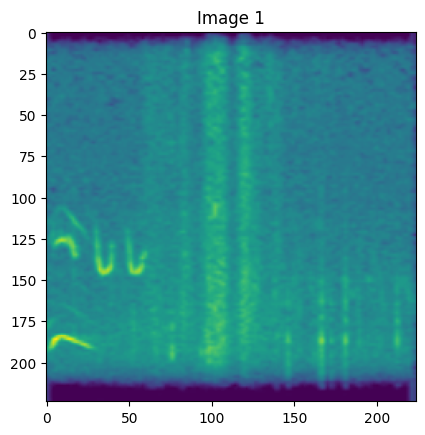

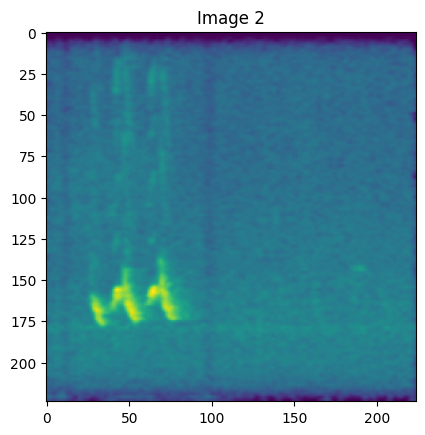

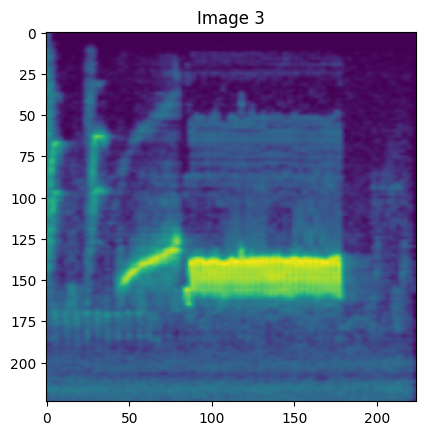

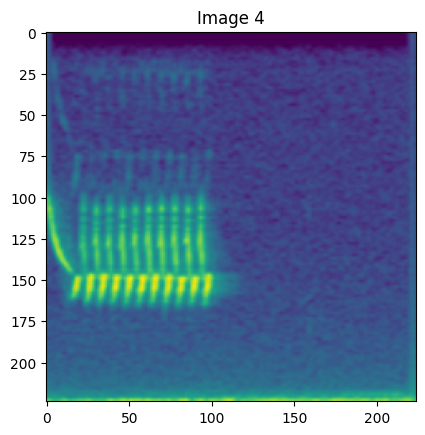

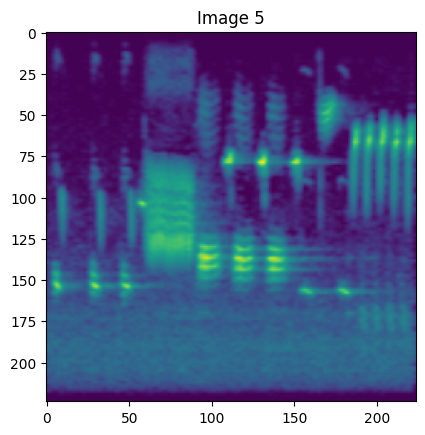

In [14]:
# Display
for i in range(5):
    image, _ = train_dataset[i]
    np_image = image.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.title(f"Image {i+1}")
    plt.show()